# Covid Proof Table Positioning

## Introduction

The problem we solve here is to position tables (or more specifically, an outer rectangle box around a table with 
people on seats around the table) w.r.t. each other in a roon. These outer rectangles cannot overlap.
If you want a more visual explanation of the problem, you can find a medium article at
https://henk-celcius.medium.com/geometric-optimisation-for-industrial-challenges-be7cf35d225d

We base ourselves on the paper of Goncalves et al. at:
https://doi.org/10.1016/j.ejor.2020.04.028
This is a MIP formulation, which we will convert to a QUBO formulation for execution on a dwave machine.

A QUBO is a Quadratic Unconstrainted Binary Optimisation problem. 
All variables are binaries,
(or sometime integers composed out of binaries, encoded in a particular way (one hot or as an unsigned int, etc.))
They occur either as linear terms or quadratic terms (but note that x = x^2 for binary x).
QUBOs are Unconstrained, so only the objective function has to be formulated.
When transforming from a MIP with constraints, the constraints have to be converted 
into (weight balanced) terms in the objective function.

For this conversion, we use the pyqubo library, https://github.com/recruit-communications/pyqubo
with docs at https://pyqubo.readthedocs.io/en/latest/
It was written by Kota Rotanahashi from recruit-communications. The resulting qubo datastructure 
can be sent to a dwave computer to be solved.

Some principles of the basics of the conversion principles of the pyqubo library are explained at:
http://www.optimization-online.org/DB_FILE/2018/11/6923.pdf

The objective function of the MIP in our table positioning problem is: 
sum_{i=1}^N   sum_{t=1}^{T}  V^t I_{i}^{t}, 
where T is the set of table types,
N^t is the number of table of type t,
N is the total number of tables of any (generic) type (N = max_t{N^t})
V^t is the value of each placed table of type t 
and I_{i}^{t} is the boolean variable that is 1 if table i is of type t and placed in the room, otherwise it's 0.

In [1]:
import math 
import pprint
import svgwrite
import json
from IPython.display import SVG, display

filename_prefix = 'Positioning'

## Choose Problem (Size) & Solving Methods

### Choose Problem (Size) 

In [2]:
# (1) Choose here which covid safe positioning problem you want to solve.
problem_large = {
    'room': {'dy':4, 'dx': 10, 'color':'green'},
    'rectangle_types': {
        'wide': {'dy': 1.2, 'dx':2.0, 'value':1.0, 
                 'max_number':6, 'color':'blue'}, # 1st table type
        'sqish': {'dy': 1.4, 'dx':1.4, 'value':4.0, 
                  'max_number':6, 'color':'orange'}, # 2nd table type
        'high': {'dy': 3, 'dx':1, 'value':2.0, 
                 'max_number':6, 'color':'brown'}, # 2nd table type
   },
}

problem_medium = {
    'room': {'dy':4, 'dx': 10, 'color':'green'},
    'rectangle_types': {
        'wide': {'dy': 1.2, 'dx':2.0, 'value':1.0, 
                 'max_number':1, 'color':'blue'}, # 1st table type
        'sqish': {'dy': 1.4, 'dx':1.4, 'value':1.0, 
             'max_number':1, 'color':'orange'}, # 2nd table type
   },
}

# We reduce the problem to stay below 119 qubits.
# For the 'ann_hw' hardware dwave machine, I get:
# ValueError: Cannot embed given BQM (size 136), sampler can only handle problems of size 119
problem_small = {
    'room': {'dy':2, 'dx': 2, 'color':'green'},
    'rectangle_types': {
        'wide': {'dy': 0.4, 'dx':0.8, 'value':1.0, 
                 'max_number':1, 'color':'blue'}, # 1st table type
        'sqish': {'dy': 1.2, 'dx':0.6, 'value':1.0, 
                  'max_number':1, 'color':'orange'}, # 2nd table type
   },
}

problem = problem_small
    
cfg_json_str = json.dumps(problem, indent=2)
print(cfg_json_str)

{
  "room": {
    "dy": 2,
    "dx": 2,
    "color": "green"
  },
  "rectangle_types": {
    "wide": {
      "dy": 0.4,
      "dx": 0.8,
      "value": 1.0,
      "max_number": 1,
      "color": "blue"
    },
    "sqish": {
      "dy": 1.2,
      "dx": 0.6,
      "value": 1.0,
      "max_number": 1,
      "color": "orange"
    }
  }
}


###  Solving Method Set

In [3]:
# This notebook can use a set of methods to solve the same problem and compare solutions.
# We altely also introduced ['cliq', 'dws', 'hyb'] as sub-methods of ann_hw, so one cannot only compare
# different software approaches, but also differentt quantum/hybrid hardware machines running the 
# same or a similar annealing technique.
# (1) This gives 7 possible methods globally.
mip_methods = ['mip_plain', 'mip_hier_obj', 'mip_qubo']
mip_methods.remove('mip_hier_obj')  # method is inpplicable here since:
# we can only define linear objective terms here 
# and we need quadratic ones for the penalities on hard mip constraints). 
# So it will not give valid solutions and we disable it here.
ann_sw_methods = ['ann_sw']
ann_hw_methods = ['ann_hw_cliq', 'ann_hw_dws', 'ann_hw_hyb']
ann_methods = ann_sw_methods + ann_hw_methods
all_implemented_methods = mip_methods + ann_methods
# If you do not have a gurobi license, just leave out 'mip' form the run_methods.
# If you have not downloaded the free leap software from dwave, just leave out 'ann_sw' form the run_methods.
# If you have not applied and been granted access to the quantum computers at dwave, 
# just leave out 'ann_hw' form the run_methods.

# (2) Choose here which subset of all_methods you want to run.
#run_methods = ['mip_plain', 'mip_qubo', 'mip_qubo', 'ann_sw'] 
run_methods = all_implemented_methods
all_big_enough_methods = all_implemented_methods.copy()
all_big_enough_methods.remove('ann_hw_cliq')  # remove is an in place method
# The dwave quatum full clique computer ann_hw_cliq can only can embed up to 119 qubits.
# That is enough for problem_small, which requires 116 qubits,
# but not for problem_medium and problem_large, which require more qubits.

all_mappable_methods = all_big_enough_methods.copy()
all_mappable_methods.remove('ann_hw_dws')
# raise ValueError("no embedding found")

# We are going to set up problems, not only for a quantum computer,
# but, just to check if our model is correct, via a trustable MIP solver: Gurobi.
# We will maximise sharing of code of this Gurobi problem with the quantum QUBO formulation,
# so that we have a method to avoid mistakes in the more tricky and less well known QUBO formulation.
# 'mip' means we formulate a MIP (mixed integer programming) model. We do this using the Gurobi API.
# 'ann_sw' means ANNealing_via_simulator_SoftWare
# 'ann_hw' methods: 3 different annealing_via_quantum_HardWare

assert set(run_methods).issubset(all_implemented_methods)

# (3) Nothing else to configure now. Just run the notebook to the end.

### Choosing Solving Method Set, Depending on the Problem

In [4]:
# You could reduce the methods set here, but they have been chosen to contain all 
# methods that work in a practical amount of time.
# For the notebook to work on your computer, you should for example 
# remove the mip methods, if you don't have a gurobi license installed,
# or the dwave machine methods if you don't have a dwave access key to their quantum computers.
all_cfg = {'small': {'problem': problem_small, 
                     'methods': all_implemented_methods
                    },
           'medium': {'problem': problem_medium, 
                      'methods': all_big_enough_methods
                      },
           'large': {'problem': problem_large, 
                     'methods': all_mappable_methods
                      },
          }

# User should change this problem_name from 'small' to 'medium' to 'large':
problem_name = 'small'  # We can run only one problem size at the time. 
# You can set the run value here to each of the keys in all_cfg.keys().
# After having done that, you will have the fiull collection of filenames
# Positioning_{problem}_{method}.svg
# Then, you can run the last cell and this shows all pictures together to get an understanding of the 
# capability of the methods for the particular problems / problem sizes.
assert problem_name in all_cfg.keys()

# The below line should be left untouched.
cfg = all_cfg[problem_name]['problem']
run_methods = all_cfg[problem_name]['methods']

## Initialize Some Constant Parameters

In [5]:
resolution_in_m = 0.1  
# The finer the resolution, the more bits needed, so this will be one control parameter
# that allows to scale the needed bits up or down when possible resp. needed.
n_x_steps = math.ceil(cfg['room']['dx'] / resolution_in_m)
n_y_steps = math.ceil(cfg['room']['dy'] / resolution_in_m)
print('n_x_steps={:d} is the number of steps for the room-range horizontal x coordinate variable of each table.'.format(n_x_steps))
print('n_y_steps={:d} is the number of steps for the room-range vertical y coordinate variable of each table.'.format(n_y_steps))
#n_bits_y = math.ceil(math.log(n_y_steps, 2))
#n_bits_x = math.ceil(math.log(n_x_steps, 2))
#print(n_y_steps, n_bits_y, n_x_steps, n_bits_x)

# room parameters:
W = cfg['room']['dx'] / resolution_in_m
H = cfg['room']['dy'] / resolution_in_m

# table type parameters:
Wt = {}
Ht = {}
Vt = {}
Nt = {}
N = 0
Wt_max = 0
Ht_max = 0
max_mip_obj = 0
for (t, (_, table_type)) in enumerate(cfg['rectangle_types'].items()):
    Wt[t] = int(table_type['dx'] / resolution_in_m + 0.5)
    Ht[t] = int(table_type['dy'] / resolution_in_m + 0.5)
    Vt[t] = table_type['value']
    Nt[t] = table_type['max_number']
    assert int(Nt[t]) == Nt[t]
    N += Nt[t]
    Wt_max = max(Wt_max, Wt[t])  # TODO: Not doing anything with 90 degree rotation yet.
    Ht_max = max(Ht_max, Ht[t])  # TODO: Not doing anything with 90 degree rotation yet.
    max_mip_obj += Nt[t] * Vt[t]  # supposing all tables can fit.
print('Wt=')
print(Wt)
print('Ht=')
print(Ht)
print('N={:d} is the maximum number of potentially placeble tables for all table types summed together.'.format(N))
print('Wt_max={:f} is the maximum width amongst all table types.'.format(Wt_max))
print('Ht_max={:f} is the maximum width amongst all table types.'.format(Ht_max))
print('max_mip_obj={:f} is (an upperbound for) the maximum value the ob]ective could ever reach.'.format(max_mip_obj))
pri = 1  # default
print('Only used in mip_hier_obj:')
pri_main = 5 * pri  # lower value, since these (original mip ony) obj term is like a 'soft' constraints.
pri_constr = 10 * pri  # higher value is more important (higher priority), 
# since these terms represent hard constraints
print('  pri_main={:f} is the priority we assign to the main mip objective.'.
      format(pri_main))
print('  pri_constr={:f} is the priority we assign to all MIP constraints '.format(pri_constr), end='')
print('(so all objective terms but the main mip one).')
      
weight_main = 1  # we don't call this a penalty as for the things deviating from zero.
pen_constr = max_mip_obj * 1.5   # we set the penaly P to this value so that hard MIP constraints,
# present in the QUBO model as terms in the QUBO ob]ective to be minimised, are more highly weighted that the
# value the ob]ective can reach.
print('weight_main={:f} is the weight factor we weight the main mip objective with.'.format(weight_main))
print('pen_constr={:f} is the weight factor we weight all MIP constraints (so other QUBO obj[m] terms) with.'.
      format(pen_constr))  
n_w_steps = math.ceil(Wt_max)
n_h_steps = math.ceil(Ht_max)
print('n_w_steps={:d} is the number of steps for the table-range horizontal w size variable of each table.'.format(n_w_steps))
print('n_h_steps={:d} is the number of steps for the table_range vertical h size variable of each table.'.format(n_h_steps))

n_x_steps=20 is the number of steps for the room-range horizontal x coordinate variable of each table.
n_y_steps=20 is the number of steps for the room-range vertical y coordinate variable of each table.
Wt=
{0: 8, 1: 6}
Ht=
{0: 4, 1: 12}
N=2 is the maximum number of potentially placeble tables for all table types summed together.
Wt_max=8.000000 is the maximum width amongst all table types.
Ht_max=12.000000 is the maximum width amongst all table types.
max_mip_obj=2.000000 is (an upperbound for) the maximum value the ob]ective could ever reach.
Only used in mip_hier_obj:
  pri_main=5.000000 is the priority we assign to the main mip objective.
  pri_constr=10.000000 is the priority we assign to all MIP constraints (so all objective terms but the main mip one).
weight_main=1.000000 is the weight factor we weight the main mip objective with.
pen_constr=3.000000 is the weight factor we weight all MIP constraints (so other QUBO obj[m] terms) with.
n_w_steps=8 is the number of steps for the

## Construct Model Variables

### Define Variable Initializing Helper Functions

In [6]:
# Create variables dictionaries, model dictionary and objective dictionary.

# Create all the variable dictionaries
# We call the Goncalves paper 'I' boolean variables 'b' here instead.
b = {}  # (i,t) bin 
# The rest of the naming is consistent with the Goncalves paper.
x = {}  # (i) int
y = {}  # (i) int
p = {}  # (i,j) bin
q = {}  # (i,j) bin
w = {}  # (i) int
h = {}  # (i) int
s2x = {}  # (i,j) int
s3x = {}  # (i,j) int
s4y = {}  # (i,j) int
s5y = {}  # (i,j) int
s10xL = {} # (i) int
s10xR = {} # (i) int
s11yL = {} # (i) int
s11yR = {} # (i) int
s12 = {}  # (i) bin
s15 = {} # (t) int
model = {} # can be mip model 
# or an annealing model (where sim sw or real harware have same model type as interface)
obj = {}

def complete_name_with_indices(name_prefix, indices):
    anonymous_indices = False
    name = name_prefix
    n_indices = 0
    for index_name, index_value in indices.items():
        if anonymous_indices:
            name += '_{:d}'.format(index_value) 
        else:
            name += '_{:s}{:d}'.format(index_name, index_value)
        n_indices += 1
    return name, n_indices

def add_var(dictionary, method, var_name, lb, ub, mip_model, indices):  
    # this can be an integer (in annealing methods) or a float (in mip method)
    full_var_name, n_indices = complete_name_with_indices(var_name, indices)
    binary = lb==0 and ub==1
    annealing = method in ann_methods
    if annealing:
        if binary:  # add a binary variable
            v = Binary(full_var_name)
        else:
            v = LogEncInteger(full_var_name, (lb, ub))
    else:  # integers or floats, depending on the method.
        assert mip_model is not None
        obj_coefficient = 0.0  # for equivalence of mip method to the annealing methods 
        # We exclude non zero obj_coefficients.
        if binary:  # add a binary variable
            v = mip_model.addVar(lb, ub, obj_coefficient, GRB.BINARY, full_var_name)
        else:
            prefer_continuous = True  # integermimicks the quantum discrete nature better, 
            # continuous is likely quicker
            var_type = GRB.CONTINUOUS if prefer_continuous else GRB.INTEGER
            v = mip_model.addVar(lb, ub, obj_coefficient, GRB.CONTINUOUS, full_var_name)

    index_value_list = []
    for index_name, index_value in indices.items():
        index_value_list.append(index_value)
        if n_indices == 1:
            dictionary[m][index_value_list[0]] = v
        else:
            assert n_indices == 2
            if len(index_value_list) == 2:
                dictionary[m][(index_value_list[0],index_value_list[1])] = v
    return v

### Actually Construct Model Variables

In [7]:
for m in run_methods: # you can read m as method or as model in the sequel
    print('\n-------------------- ' + problem_name + '_' + m + ' --------------------')
    b[m] = {}  # (i,t) bin 
    x[m] = {}  # (i) int
    y[m] = {}  # (i) int
    p[m] = {}  # (i,j) bin
    q[m] = {}  # (i,j) bin
    w[m] = {}  # (i) int
    h[m] = {}  # (i) int
    s2x[m] = {}  # (i,j) int
    s3x[m] = {}  # (i,j) int
    s4y[m] = {}  # (i,j) int
    s5y[m] = {}  # (i,j) int
    s10xL[m] = {} # (i) int
    s10xR[m] = {} # (i) int
    s11yL[m] = {} # (i) int
    s11yR[m] = {} # (i) int
    s12[m] = {}  # (i) bin
    s15[m] = {} # (t) int
    
    model[m] = None  # different type of model for mip and for annealing
    # obj[m] is initialized in the next cell below.

    if m in mip_methods:
        import gurobipy as gp
        a = False  # you can read isq as must do annealing stuff (i.o mip)
        from gurobipy import GRB
        model[m] = gp.Model()
    elif m in ann_methods:
        from pyqubo import LogEncInteger, Binary, Constraint
        import dimod
        a = True # you can read 1 as must do annealing stuff (i.o mip)
        model[m] = None  # nothing needed here yet. We will fill it with an annealing model later.
    else:
        assert False

    for i in range(N):
        assert isinstance(i, int)
        
        # Note that in this loop. model[m], the rhs is only not None for where m is 'mip', so:
        if m in ['mip_plain', 'mip_hier_obj', 'mip_qubo']:
            assert model[m] is not None
        else:  # annealing / QUBO model
            assert model[m] is None
        
        for (t, (table_type_name, table_type)) in enumerate(cfg['rectangle_types'].items()):
            #b[m][(i,t)] = Binary('b_{:d}_{:d}'.format(i,t))
            add_var(b, m, 'b', 0.0, 1.0, model[m], {'i': i, 't':t})
            
        #x[m][i] = LogEncInteger('x_{:d}'.format(i), (0.0, n_x_steps-1))
        add_var(x, m, 'x', 0, n_x_steps, model[m], {'i': i})  # dropped -1
        
        #y[m][i] = LogEncInteger('y_{:d}'.format(i), (0.0, n_y_steps-1))
        add_var(y, m, 'y', 0, n_y_steps, model[m], {'i': i})  # dropped -1
        
        #w[m][i] = LogEncInteger('w_{:d}'.format(i), (0.0, n_w_steps-1))
        add_var(w, m, 'w', 0, n_w_steps, model[m], {'i': i})  # dropped -1

        #h[m][i] = LogEncInteger('h_{:d}'.format(i), (0.0, n_h_steps-1))
        add_var(h, m, 'h', 0, n_h_steps, model[m], {'i': i})  # dropped -1

        #s10xL[m][i] = LogEncInteger('s10xL_{:d}'.format(i), (0.0, n_x_steps-1))
        add_var(s10xL, m, 's10xL', 0, n_x_steps, model[m], {'i': i})  # dropped -1

        #s10xR[m][i] = LogEncInteger('s10xR_{:d}'.format(i), (0.0, n_x_steps-1))
        add_var(s10xR, m, 's10xR', 0, n_x_steps, model[m], {'i': i})  # dropped -1

        #s11yL[m][i] = LogEncInteger('s11yL_{:d}'.format(i), (0.0, n_y_steps-1))
        add_var(s11yL, m, 's11yL', 0, n_y_steps, model[m], {'i': i})  # dropped -1

        #s11yR[m][i] = LogEncInteger('s11yR_{:d}'.format(i), (0.0, n_y_steps-1))
        add_var(s11yR, m, 's11yR', 0, n_y_steps, model[m], {'i': i})  # dropped -1

        #s12[m][i] = Binary('s12_{:d}'.format(i))
        add_var(s12, m, 's12', 0, 1, model[m],  {'i': i})

        for j in range(i+1, N):
            assert i < j
            #p[m][(i,j)] = Binary('p_{:d}_{:d}'.format(i,j))
            add_var(p, m, 'p', 0, 1, model[m], {'i': i, 'j': j})

            #q[m][(i,j)] = Binary('q_{:d}_{:d}'.format(i,j))
            add_var(q, m, 'q', 0, 1, model[m],  {'i': i, 'j': j})

            # TODO: with the 2* range extention for the slack vars below, we get feasibility when 
            # more than one table is allowed, otherwise not. Strange. To be fixed...
            
            #s2x[m][(i,j)] = LogEncInteger('s2x_{:d}_{:d}'.format(i,j), (0.0, n_x_steps-1))
            # 0.18 goes ok, 0.17 goes wrong for ioOne. At least for slack debug case in cfg.
            ioOne = 2 # TODO: I would think 1.0 should be enough. Investigate why we need more...
            add_var(s2x, m, 's2x', 0, ioOne*n_x_steps, model[m], {'i': i, 'j': j})  # dropped -1, replaced with 2*

            #s3x[m][(i,j)] = LogEncInteger('s3x_{:d}_{:d}'.format(i,j), (0.0, n_x_steps-1))
            add_var(s3x, m, 's3x', 0, ioOne*n_x_steps, model[m], {'i': i, 'j': j})  # dropped -1, replaced with 2*

            #s4y[m][(i,j)] = LogEncInteger('s4y_{:d}_{:d}'.format(i,j), (0.0, n_y_steps-1))
            add_var(s4y, m, 's4y', 0, ioOne*n_y_steps, model[m], {'i': i, 'j': j})  # dropped -1, replaced with 2*

            #s5y[m][(i,j)] = LogEncInteger('s5y_{:d}_{:d}'.format(i,j), (0.0, n_y_steps-1))
            add_var(s5y, m, 's5y', 0, ioOne*n_y_steps, model[m], {'i': i, 'j': j})  # dropped -1, replaced with 2*

    for (t, (_, _)) in enumerate(cfg['rectangle_types'].items()):
        #s15[m][t] = LogEncInteger('s15_{:d}'.format(t), (0.0, nt[t]-1))
        add_var(s15, m, 's15', 0, Nt[t], model[m], {'t': t})  # dropped -1


-------------------- small_mip_plain --------------------
Using license file /Library/gurobi910/gurobi.lic

-------------------- small_mip_qubo --------------------

-------------------- small_ann_sw --------------------

-------------------- small_ann_hw_cliq --------------------

-------------------- small_ann_hw_dws --------------------

-------------------- small_ann_hw_hyb --------------------


In [8]:
# One can debug by outcommenting a statement below.

#print(b)
#print(x)
#print(y)

## Construct Model Constraints

### Define Constraint Constructing Helper Functions

In [9]:
# Create constraints, which are real constraints for the mip model,
# but just penalised terms for the annealing models.
def add_constr(obj_m, obj_index_list, priority, penalty, expr_to_be_zero_or_minimized, method, constr_name,
               mip_model, indices):
    verbose = 1  # shh-ish
    
    weighted_qt = 0  # This is the start for all branches in here.
    full_constr_name, n_indices = complete_name_with_indices(constr_name, indices)        
    annealing = method in ann_methods
    if annealing:  # QUBO models have no constraints. 
        # The best we can do is penalise the non-equality part in the obj[m]
        weighted_qt = penalty * Constraint(expr_to_be_zero_or_minimized ** 2, label=full_constr_name) 
        #obj_m += weighted_qt
        # a QUBO 'constraint'
    else:  # mip
        assert m in mip_methods
        # TODO: avoid these exceptions ['eq12', 'eq13', 'eq14', 'eq15'] in line below
        exceptions = []
        #exceptions.extend(['eq2', 'eq3', 'eq4', 'eq5'])
        #exceptions.extend(['eq12', 'eq13', 'eq14', 'eq15'])
        if (exceptions != []) and (m not in ['mip_hier_obj']):  # Then you have something quadratic + constraints.
            if model[m].Params.NonConvex != 2:  # only do this once since Gurobi prints a line whenever it's changed.
                model[m].Params.NonConvex = 2
        if m == 'mip_plain' or ((m in ['mip_hier_obj', 'mip_qubo']) 
                                and (constr_name in exceptions)):  # normal mip mode
            mip_model.addConstr(expr_to_be_zero_or_minimized == 0, full_constr_name) # add a real mip constraint
            assert weighted_qt == 0
        else:
            assert m in ['mip_hier_obj', 'mip_qubo']
            if verbose >=2:
                print('Adding extra terms to mip obj_m because of mip_mimicking_qubo. constr_name={:s}, Penalty={:.4f}.'.\
                      format(constr_name, penalty))
                print('indices =')
                print(indices)
            if m in ['mip_qubo']:
                quadratic_term = expr_to_be_zero_or_minimized * expr_to_be_zero_or_minimized
                weighted_qt = penalty * quadratic_term
                if verbose >=2:
                    print('adding weighted_qt=')
            else:
                assert m in ['mip_hier_obj']
                # theory: https://www.gurobi.com/documentation/9.1/refman/working_with_multiple_obje.html
                # practice: https://www.gurobi.com/documentation/9.1/refman/py_model_setobjectiven.html
                
                # GurobiError: Objective must be linear for multi-objective model
                # This means that these terms can be negative, and this mip_hier_obj will in geeneral not give
                # valid solutions. (You can try it though.)
                if verbose >=2:
                    print('obj_index = {:d}'.format(obj_index_list[0]))
                model[m].setObjectiveN(expr_to_be_zero_or_minimized, index=obj_index_list[0], 
                                       priority=priority, weight=penalty)
                obj_index_list[0] += 1  # by pretending it is a list and incrementing the first list element.
                if verbose >=2:
                    print('adapted obj_index = {:d}'.format(obj_index_list[0]))
                weighted_qt = 0 # we don't want to add objective N to the original objective.
            #print(weighted_qt)
            #obj_m += weighted_qt  # just as the qubo does
    # dirty trick to increment an integer passed to a function in the function itself:
    return weighted_qt  # we could do addition of this to obj_m in place, but somehow this fails.
    # so we do it in the caller instead.         

### Actually Construct Model Constraints

In [10]:
obj_mip_obj = {}

# Build up original MIP objective (without terms for (energy terms of) constraints).
for m in run_methods: # you can read m as method or as model in the sequel
    print('\n-------------------- ' + problem_name + '_' + m + ' --------------------')
    assert isinstance(i, int)

    # Note that in this loop. mip_model=model[m], the rhs is only not None for where m is 'mip', so:
    if m in mip_methods:
        assert model[m] is not None
    else: # annealing / QUBO model
        assert model[m] is None

    obj_mip_obj[m] = 0  # That's where it starts for both model types: mip or annealing.
    for i in range(N):
        for (t, (table_type_name, table_type)) in enumerate(cfg['rectangle_types'].items()):
            obj_mip_obj[m] -= b[m][(i,t)] * Vt[t]  
            # Note the - i.o. + sign because we minimise - the table values, 
            # for compatibility with energy minimisation in the annealing methods.
            # This holds for both mip and annealing models.
    # For m = mip_plain, the objective is complete here, and the rest to add below is constraints.
    # For all other models, we add the 'constraints' as penalised positive objective terms below.
    
    obj_index_list = [0]  # only gets used for m == 'mip_hier_obj'. The 0 index was used for the main original mip method.
    if m in ['mip_hier_obj']:
        print('obj_index = {:d}'.format(obj_index_list[0]))
        model[m].setObjectiveN(obj_mip_obj[m], index=obj_index_list[0], priority=pri_main, weight=weight_main)
        obj[m] = 0  # TODO: This is enough for now, but could be improved by setting obj[m]obj_index_list to the proper expression.
    else:
        obj[m] = obj_mip_obj[m]
    # Complete the objective from MIP objective to QUBO objective.
    # The pri_constr, pen_constr, logic here is this:
    # Only for the mip_hier_obj with hierarchical objectives for Gurobi, do we really use the priority (pri) value.
    # This is done inside the add_constr method itself.
    # For the other methods, we don't use it. So the values set in the calls here, can directly be (and are)
    # the ones for mip_hier_obj. For mip_hier_obj, the only requirement priority wise, to get a valid solution 
    # for the original mip problem, is that the priority of each of the 'constraints' is higher 
    # than the priority of the original mip objective. 
    # So 2 for the original mip obj and 1 for the add_constr (or pri_constr and 1*pri) will do then. 
    # So that's what we set them to here.
    for i in range(N):
        for j in range(i+1, N):
            assert i < j
            # note the += (i.o. -=) for all terms added. W minimise the obj[m] (for all methods).
            # to the added terms here are pushed to be minimal, which is the idea, they hsould in fact be all zeor
            # for a valid solution. So, we give them a high penalty pen_constr, that exceeds even a low value (1)
            # of the mip objective. This seems, at least, to work for m == 'mip_qubo'.
            lin2_ij = 2*( x[m][i] - x[m][j] + W * (p[m][i,j] + q[m][i,j]) - s2x[m][(i,j)] ) - (w[m][i]+w[m][j])
            obj[m] += add_constr(obj[m], obj_index_list, pri_constr, pen_constr, lin2_ij, m, 
                                 'eq2', model[m], {'i': i, 'j': j})
            
            lin3_ij = 2*( x[m][j] - x[m][i] + W * (1-p[m][i,j] + q[m][i,j]) - s3x[m][(i,j)] ) - (w[m][i]+w[m][j])
            obj[m] += add_constr(obj[m], obj_index_list, pri_constr, pen_constr, lin3_ij, m, 
                                 'eq3', model[m], {'i': i, 'j': j})
            
            lin4_ij = 2*( y[m][i] - y[m][j] + H * (  p[m][i,j] + 1-q[m][i,j]) - s4y[m][(i,j)] ) - (h[m][i]+h[m][j])
            obj[m] += add_constr(obj[m], obj_index_list, pri_constr, pen_constr, lin4_ij, m, 
                                 'eq4', model[m], {'i': i, 'j': j})
            
            lin5_ij = 2*( y[m][j] - y[m][i] + H * (1-p[m][i,j] + 1-q[m][i,j]) - s5y[m][(i,j)] ) - (h[m][i]+h[m][j])
            obj[m] += add_constr(obj[m], obj_index_list, pri_constr, pen_constr, lin5_ij, m, 
                                 'eq5', model[m], {'i': i, 'j': j})

        lin10L_i = (w[m][i]/2 + s10xL[m][i] - x[m][i])
        obj[m] += add_constr(obj[m], obj_index_list, pri_constr, pen_constr, lin10L_i, m, 
                             'eq10L', model[m], {'i': i})
        
        lin10R_i = (x[m][i] + s10xR[m][i] - W + w[m][i]/2)
        obj[m] += add_constr(obj[m], obj_index_list, pri_constr, pen_constr, lin10R_i, m, 
                             'eq10R', model[m], {'i': i})
        
        lin11L_i = (h[m][i]/2 + s11yL[m][i] - y[m][i])
        obj[m] += add_constr(obj[m], obj_index_list, pri_constr, pen_constr, lin11L_i, m, 
                             'eq11L', model[m], {'i': i})
        
        lin11R_i = (y[m][i] + s11yR[m][i] - H + h[m][i]/2)
        obj[m] += add_constr(obj[m], obj_index_list, pri_constr, pen_constr, lin11R_i, m, 
                             'eq11R', model[m], {'i': i})

        lin12_i = 1 - s12[m][i]  # eq (12) 1 - [slack variable] for inequality
        lin13_i = w[m][i]  # eq(13) lhs
        lin14_i = h[m][i]  # eq(14) lhs
        for (t, (_, _)) in enumerate(cfg['rectangle_types'].items()):
            lin12_i -= b[m][(i,t)]  # eq (12)
            lin13_i -= b[m][(i,t)] * Wt[t]  # eq (13) rhs
            lin14_i -= b[m][(i,t)] * Ht[t]  # eq (14) rhs

        # The following constraints are amongst binaries, a diffefrence of 1 should be heavely penalised.
        
        #obj[m] += P * Constraint(lin12_i ** 2, label='eq12_{:d}'.format(i))
        # eq (12): so this lin term is pos & minimal when *at most* one b[(i,t)] is 1. 
        # if none of them is, then s(i,t) must be 1 (at optimality), for all i
        obj[m] += add_constr(obj[m], obj_index_list, pri, pen_constr, lin12_i, m, 'eq12', model[m], {'i': i})

        #obj[m] += 3 * P * Constraint(lin13_i ** 2, label='eq13_{:d}'.format(i))
        # eq (13): so this lin term is pos & minimal when w[t] = sum_t b[(i,t)]*Wt[t], for all i
        obj[m] += add_constr(obj[m], obj_index_list, pri, pen_constr, lin13_i, m, 'eq13', model[m], {'i': i})

        #obj[m] += 3 * P * Constraint(lin14 ** 2, label='eq14_{:d}'.format(i))
        # eq (14): so this lin term is pos & minimal when h[t] = sum_t b[(i,t)]*Ht[t], for all i
        obj[m] += add_constr(obj[m], obj_index_list, pri, pen_constr, lin14_i, m, 'eq14', model[m], {'i': i})

    # The following constraints are amongst binaries, a diffefrence of 1 should be heavely penalised.
    for (t, (_, _)) in enumerate(cfg['rectangle_types'].items()):
        lin15_t = Nt[t] - s15[m][t]
        for i in range(N):
            lin15_t -= b[m][(i,t)]
        #obj[m] += P *  Constraint(lin15 ** 2, label='eq15_{:d}'.format(t))
        # eq (15) so this lin term is pos & minimal when Nt[t] = s15[t] + sum_i b[(i,t)], for all t
        obj[m] += add_constr(obj[m], obj_index_list, pri, pen_constr, lin15_t, m, 'eq15', model[m], {'t': t})

    annealing = m in ann_methods
    if annealing:  # special step for annealing QUBO models
        model[m] = obj[m].compile()
    else:
        pass  # nothing to do here for mpi model
    
    #print(obj[m]


-------------------- small_mip_plain --------------------

-------------------- small_mip_qubo --------------------

-------------------- small_ann_sw --------------------

-------------------- small_ann_hw_cliq --------------------

-------------------- small_ann_hw_dws --------------------

-------------------- small_ann_hw_hyb --------------------


### Helper Function for Multi-Objective Case

In [11]:
# from: https://www.gurobi.com/documentation/9.1/refman/working_with_multiple_obje.html
def query_multi_objective(m): # Read and solve a model with multiple objectives
    # get the set of variables
    x = m.getVars()

    # Ensure status is optimal
    assert m.Status == GRB.Status.OPTIMAL

    # Query number of multiple objectives, and number of solutions
    nSolutions  = m.SolCount
    nObjectives = m.NumObj
    print('Problem has', nObjectives, 'objectives')
    print('Gurobi found', nSolutions, 'solutions')

    # For each solution, print value of first three variables, and
    # value for each objective function
    solutions = []
    for s in range(nSolutions):
        # Set which solution we will query from now on
        m.params.SolutionNumber = s

        # Print objective value of this solution in each objective
        print('Solution', s, ':', end='')
        for o in range(nObjectives):
            # Set which objective we will query
            m.params.ObjNumber = o
            # Query the o-th objective value
            print(' ', m.ObjNVal, end=', ')

    # print first three variables in the solution
    max_n_vars = 100
    n_vars = min(len(x), max_n_vars)
    for j in range(n_vars):
        print(x[j].VarName, x[j].Xn, end=', ')
    print('')

    # query the full vector of the o-th solution
    solutions.append(m.getAttr('Xn', x))

### Actually Solve Models with Selected Methods & Show Partial Results

In [12]:
#print(obj[m])

In [13]:
from dwave.system import DWaveCliqueSampler, EmbeddingComposite, DWaveSampler, LeapHybridSampler

#from dwave.cloud.solver import BQMSolver
#sampler = BQMSolver(client=client, data={id:'hybrid_binary_quadratic_model_version2'})  
# id='hybrid_binary_quadratic_model_version2'

def select_the_right_solver_name(want_more_than_119_qubits, i_want_a_quantum_only_machine):
    # I got some guidance here from Luca W on:
    # https://support.dwavesys.com/hc/en-us/community/posts/1500000142522-How-to-avoid-violated-constraints-with-pyqubo-?page=1#community_comment_1500000145941            
    # Luca at dwave answered this:
    #The graph size of 119 you found is the largest fully-connected network when mapped 
    #to the Advantage QPU. For sparser networks, i.e. not all variables interact with each other, 
    #I would recommend a different sampler, for example the EmbeddingComposite. 
    #If your problem is larger than the QPU, the LeapHybridSampler would be a good option - 
    #it combines quantum and classical resources to solve very large and complex problems. 
    #Here is some documentation on available solvers in Ocean:
    #https://docs.ocean.dwavesys.com/projects/system/en/stable/reference/samplers.html
    if not want_more_than_119_qubits:
        # (1) DWaveCliqueSampler:
        # DWaveCliqueSampler contains a fully connected clique of 119 qubits. 
        # which is just enough for the smallest problem in the cfg. Thanks for explaining that Luca. :)
        return 'DWaveCliqueSampler'  # works for very small examples (<=119 qubits)
    else:
        assert want_more_than_119_qubits
        if i_want_a_quantum_only_machine:
            # (2) EmbeddingComposite has more but smaller fully connected qubit sets. 
            # This is the quantum branch, 
            # for cfg = small_example, I consistently experience around 14,..17,18 violations here.
            return 'DWaveSampler'  # This seems to start and give some output,
            # but I never get to see the print('Done with this part.') at the end of this cell,
            # so it seems to be 'hanging' ...?
        else:  # This is the hybrid branch. I experience no violations here with this model.
            # (3) LeapHybridSampler
            return 'LeapHybridSampler'
            # ERROR: later leads to: SolverFailureError: Unknown parameter num_reads
            # in call: sampleset[m] = sampler.sample(bqm[m], num_reads=n_samples[m])
            # so I leave out the num_reads=n_samples[m], but then get an empty solution apparantly.
            
def init_solver_by_abbreviation(solver_abbreviation):
    assert solver_abbreviation in ['cliq', 'dws', 'hyb']
    d = {'cliq': 'DWaveCliqueSampler', 'dws': 'DWaveSampler', 'hyb': 'LeapHybridSampler'}
    return init_solver_by_name(d[solver_abbreviation])

def init_solver_by_name(solver_name):
    supports_n_samples = True
    assert solver_name in ['DWaveCliqueSampler', 'DWaveSampler', 'LeapHybridSampler']
    if solver_name == 'DWaveCliqueSampler':
        return DWaveCliqueSampler(), supports_n_samples
    elif solver_name == 'DWaveSampler':
        return EmbeddingComposite(DWaveSampler()), supports_n_samples
    elif solver_name == 'LeapHybridSampler':
        return LeapHybridSampler(), not supports_n_samples

# mip methods:
# input:
required_max_time_limit_s = {}
required_max_time_limit_s['mip_plain'] = 300  # No more patience than that
required_max_time_limit_s['mip_hier_obj'] = 300  # Normally None, since should run to the end 
# to avoid violations in hard constraints. However, for practical reasons this can be too long a wait.
required_max_time_limit_s['mip_qubo'] = 300  # idem
#required_max_time_limit_s['ann_sw'] = None  # idem
#required_max_time_limit_s['ann_hw'] = None  # idem

required_max_mip_gap = {}
required_max_mip_gap['mip_plain'] = None
required_max_mip_gap['mip_hier_obj'] = None
required_max_mip_gap['mip_qubo'] = None  
#required_max_mip_gap['ann_sw'] = None
#required_max_mip_gap['ann_hw'] = None

# required_max_time_limit_s # (1) Stop after searching this many seconds: [None or a float or int]
# or/and
# required_max_mip_gap  # 0.05 (2) Stop at this or lower fraction [None or a float or int]
# between solution and estimated upperbound:
# , whatever comes first.

# output:
mip_gap_reached = {}
objective_value_reached = {}
solver_time_used_s = {}
feasible = {}

# annealing methods:
# towards output:
bqm = {}
n_samples = {}
sampleset = {}
decoded_samples = {}
best_sample = {}
n_samples['ann_sw'] = 100
n_samples['ann_hw_cliq'] = 1000
n_samples['ann_hw_dws'] = 1000
n_samples['ann_hw_hyb'] = 1000

# ann_hw_methods
for m in run_methods: # you can read m as method or as model in the sequel    
    print('\n-------------------- ' + problem_name + '_' + m + ' --------------------')
    if m in mip_methods:
        model[m].ModelSense = gp.GRB.MINIMIZE  # gp.GRB.MAXIMIZE, we minimise to be compatible with the 
        # annealing methods which require minimisation ('coz the obj there is energy)')
        if m not in ['mip_hier_obj']:
            model[m].setObjective(obj[m])
        else:
            pass  # multiple objectives already separately set by setObjectoiveN call, do not override here.
        assert required_max_time_limit_s[m] is None or \
            isinstance(required_max_time_limit_s[m], float) or \
            isinstance(required_max_time_limit_s[m], int)
        assert required_max_mip_gap[m] is None or \
            isinstance(required_max_mip_gap[m], float) or \
            isinstance(required_max_mip_gap[m], int) 
        
        if required_max_time_limit_s[m] is not None:
            model[m].params.Timelimit = required_max_time_limit_s[m]
        if required_max_mip_gap[m] is not None:
            model[m].params.MIPGap = required_max_mip_gap[m]           
        
        lp_filename = '{:s}_{:s}_{:s}_Gurobi.lp'.format(filename_prefix, problem_name, m)
        model[m].write(lp_filename)        
        model[m].optimize()  # with Gurobi
        #status = GRB.Status
        status = model[m].Status
        print('status=')
        print(status)
        if status == GRB.INFEASIBLE:
            feasible[m] = False
            print('Model is infeasible.')
            model[m].computeIIS()
            ilp_filename = '{:s}_{:s}_{:s}_Gurobi.ilp'.format(filename_prefix, problem_name, m)
            model[m].write(ilp_filename)
            print('  -> Wrote out Irreducible Inconsistent Subsystem (IIS) to file: \'{:s}\''.format(ilp_filename))
            ilp_file = open(ilp_filename,'r')
            ilp_contents = ilp_file.read()
            print('\nSo the following equations and/or variable type and/or range limits')
            print('  are the smallest infeasible subset found in the full model.\n')
            print('*** ilp_contents begin ***')
            print(ilp_contents)
            print('*** ilp_contents end ***')
            ilp_file.close()
            assert False
        else:
            assert status in [GRB.OPTIMAL, GRB.TIME_LIMIT, GRB.USER_OBJ_LIMIT]
            feasible[m] = True
            if status == GRB.OPTIMAL:
                print('Model is solved optimally.')
            elif status == GRB.TIME_LIMIT:
                print('Model solving was interrupted at reaching of user specified time limit.')
            elif status == GRB.USER_OBJ_LIMIT:
                print('Model solving was interrupted at reaching of user specified mip gap limit.')                
            objective_value_reached[m] = model[m].objVal
            if m in ['mip_hier_obj']:
                query_multi_objective(model[m])
            else:
                mip_gap_reached[m] = model[m].MIPGap
                print('mip_gap_reached is {:f}.'.format(mip_gap_reached[m]))
                print('objective_value_reached is {:f}.'.format(objective_value_reached[m]))    
        solver_time_used_s[m] = model[m].Runtime
        print('Spent {:f} seconds calculating.'.format(solver_time_used_s[m]))  
    else:
        #used_LeapHybridSampler = False
        supports_n_samples = True
        #qubo, offset = model.to_qubo()  # why would we need this?
        if m in ['ann_sw']:
            pass
            import neal
            sampler = neal.SimulatedAnnealingSampler()
        else:  # solve on a real dwave quantum computer
            assert m in ann_hw_methods
            from dwave.cloud import Client
            # do not expose this:
            by_explicit_token_in_code = True
            if by_explicit_token_in_code:
                client = Client.from_config(token='DEV-1111111111111111111111111111111111111111')
            else:  # TODO: get this branch working without parse error
                # so this is anonymous an non revealing:
                client = Client.from_config(config_file='~/projects/dwave/MyDWaveQiskitApiToken.conf') 
            client.get_solvers()
            print(client.get_solvers())
                        
            #sampler_abbrev = 'hyb'
            sampler_abbrev = m.split('_')[-1]  # for example gives: m='ann_hw_hyb' -> sample_abbrev='hyb'
            print('sampler_abbrev = ' + sampler_abbrev)
            sampler, supports_n_samples = init_solver_by_abbreviation(sampler_abbrev)
            
            if sampler_abbrev not in ['dws']:
                sampler.parameters
                print(sampler.parameters)
            
        # For annealing models, we get common sampling code here to get the ebst sample.
        bqm[m] = model[m].to_bqm()
        if not (m in ann_methods and not supports_n_samples):
            sampleset[m] = sampler.sample(bqm[m], num_reads=n_samples[m])
        else: # num_reads arg not supported
            assert not supports_n_samples
            sampleset[m] = sampler.sample(bqm[m])
        
        decoded_samples[m] = model[m].decode_sampleset(sampleset[m])
        best_sample[m] = min(decoded_samples[m], key=lambda f: f.energy)
        #best_sample.sample # doctest: +SKIP
        #print(best_sample.sample)

print('Done with solving part for all solver methods.')


-------------------- small_mip_plain --------------------
Changed value of parameter Timelimit to 300.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 20 rows, 30 columns and 76 nonzeros
Model fingerprint: 0x52204a19
Variable types: 20 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [5e-01, 4e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 0 rows and 12 columns
Presolve time: 0.00s
Presolved: 20 rows, 18 columns, 64 nonzeros
Variable types: 8 continuous, 10 integer (6 binary)

Root relaxation: objective -2.000000e+00, 10 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      

### Show Full Solution from Annealing Methods

In [14]:
def close_int(value, tol=1e-6):
    return value  # TODO: remove function if as silly as this (for now)

    int_val = int(round(value))

    if value >= -tol:
        if int_val == 0:
            return 0
        return value # 0    
    
    # value is a float that is usually ver close to an int, return the int if closer than tol.
    if abs(value - int_val) <= tol:  # We are close to an int
        return int_val
    else:
        assert False  # if strict
        return value

for m in run_methods: # you can read m as method or as model in the sequel
    print('\n-------------------- ' + problem_name + '_' + m + ' --------------------')
    if m in ann_methods:  
        continue  # TODO: Disable this for now...
        vars = list(zip(['b'], [b]))
        for (var_name, var) in vars:
            print(var_name + ':')

            line = 'i\\t'
            for (t, (_, _)) in enumerate(cfg['rectangle_types'].items()):
                line += ' {:d}'.format(t)
            print(line)

            for i in range(N):
                line = '{:d}  '.format(i)
                for (t, (_, _)) in enumerate(cfg['rectangle_types'].items()):
                    s = var_name + '_i{:d}_t{:d}'.format(i, t)
                    val = best_sample[m].sample[s]
                    line += ' {:d}'.format(val)  # is always 0 or 1
                print(line)

        vars = list(zip(['x', 'y', 'w', 'h', 's10xL', 's10xR', 's11yL', 's11yR', 's12'],\
                        [x, y, w, h, s10xL, s10xR, s11yL, s11yR, s12]))
        for (var_name, var) in vars:
            print(var_name + ':')

            line = ' \\i '
            for i in range(N):
                line += ' {:3d}'.format(i)
            print(line)

            line = ' ' * (3+1)
            for i, _ in var.items():
                print(i)
                assert isinstance(i, int)
                s = var_name + '_{:d}'.format(i)        
                if var_name in ['s12']:
                    val = best_sample[m].sample[s]
                    assert val in [0, 1]
                else:
                    val = best_sample[m].subh[s]
                    assert int(val) == val
                    assert val >= 0
                line += ' {:3d}'.format(int(val))
            print(line)

        vars = list(zip(['p', 'q', 's2x', 's3x', 's4y', 's5y'], [p, q, s2x, s3x, s4y, s5y]))
        for (var_name, var) in vars:
            print(var_name + ':')

            line = 'i\\j '
            for j in range(N):
                line += ' {:3d}'.format(j)
            print(line)

            for i in range(N):
                line = ' {:3d}'.format(i)
                for j in range(N):
                    if j<=i:
                        line += ' ' * (3+1)
                    else:
                        s = var_name + '_{:d}_{:d}'.format(i, j)
                        if var_name in ['p', 'q']:
                            val = best_sample[m].sample[s]
                            assert val in [0, 1]
                            line += ' {:3d}'.format(val)  # is always 0 or 1
                        else:
                            val = best_sample[m].subh[s]
                            assert val == int(val)
                            assert val >= 0
                            line += ' {:3d}'.format(int(val))  # is always a positive integer
                print(line)
    else:  # gurobi
        assert m in mip_methods
        continue  # disable this for now
        # TODO: Make this work generally, for all m that can occur here
        vars = model[m].getVars()
        for v in vars:
            print('{:s} = {:f} ~= {:f}'.format(v.varName, v.x, close_int(v.x)))


-------------------- small_mip_plain --------------------

-------------------- small_mip_qubo --------------------

-------------------- small_ann_sw --------------------

-------------------- small_ann_hw_cliq --------------------

-------------------- small_ann_hw_dws --------------------

-------------------- small_ann_hw_hyb --------------------


## Inspect Best Sample Solution Returned from Annealing Methods

### Show Full Solution Itself

In [15]:
verbose = 1
for m in run_methods: # you can read m as method or as model in the sequel
    print('\n-------------------- ' + problem_name + '_' + m + ' --------------------')
    if m in ann_methods:
        if verbose >= 2:
            print(best_sample[m])
    #decoded_sample = model.decode_sample(best_sample[m].sample) # vartype='BINARY')


-------------------- small_mip_plain --------------------

-------------------- small_mip_qubo --------------------

-------------------- small_ann_sw --------------------

-------------------- small_ann_hw_cliq --------------------

-------------------- small_ann_hw_dws --------------------

-------------------- small_ann_hw_hyb --------------------


### Check for Violated Constraints

In [16]:
broken_constr_dict = {}
n_violated_constraints = {}
for m in run_methods: # you can read m as method or as model in the sequel
    print('\n-------------------- ' + problem_name + '_' + m + ' --------------------')
    if m in ann_methods:
        broken_constr_dict[m] = best_sample[m].constraints(only_broken=True)
        n_violated_constraints[m] = len(broken_constr_dict[m].keys())
        print('{:d} constraints are violated.'.format(n_violated_constraints[m]))
        verbose = 0
        if verbose >= 1:
            print(broken_constr_dict[m])


-------------------- small_mip_plain --------------------

-------------------- small_mip_qubo --------------------

-------------------- small_ann_sw --------------------
0 constraints are violated.

-------------------- small_ann_hw_cliq --------------------
19 constraints are violated.

-------------------- small_ann_hw_dws --------------------
18 constraints are violated.

-------------------- small_ann_hw_hyb --------------------
0 constraints are violated.


## Visualize Output

### Postprocess Solutions to SVG Plots

In [17]:
tol = 1e-6

assert cfg['room']['dy'] / resolution_in_m == H
assert cfg['room']['dx'] / resolution_in_m == W

verbose = 0
svg_filename = {}
stroke_width = 2
for m in run_methods: # you can read m as method or as model in the sequel
    print('\n-------------------- ' + problem_name + '_' + m + ' --------------------')
    if m in mip_methods:
        a = False  # a= annealing
    else:
        a = True  # a= annealing
    # TODO: Should we be permissive for m=='mip_hier_obj'? Test...
    permissive = m in ['mip_hier_obj', 'mip_qubo'] + ann_methods # a or (not a and global_mip_mimicking_qubo)
    severity = 'WARNING' if permissive else 'ERROR'
    if severity == 'WARNING':
        print('With this solving method, you can potentially get ' + severity + ' messeges.')
        print('This should only occur if you got \'constraint \'violations above,')
        print('because in this method \'constraints \' are really modelled als terms to minimise in the objective,')
        print('but then they are not exactly zero, the constraints are effectively violated.')
    else:
        print('With this solving method, you could potentially get ' + severity + ' messeges.')
        print('However, since the MILP model code is working fine, this should never happen here, ')
        print('since you should not have seen violated constraints above,')
        print('since constraints are enforced the hard way in this method ')
        print('and no solution is returned if any of them is not satisfied.')
        
    s = pixels_per_m = 7  # scale
    o = 20  # offset pixels
    svg_filename[m] = '{:s}_{:s}_{:s}.svg'.format(filename_prefix, problem_name, m)
    dwg = svgwrite.Drawing(svg_filename[m], profile='full', 
                           size=((2*(stroke_width+o)+W*s), (2*(stroke_width+o)+H*s)))
    room_color = cfg['room']['color']
    dwg.add(dwg.rect((o, o), (W*s, H*s), stroke=room_color,  stroke_width=stroke_width,
                     fill=room_color, opacity=0.3))
    for i in range(N):
        if verbose >= 2:
            print('i = {:d}'.format(i))
        for j in range(i+1, N):
            if verbose >= 2:
                print('  j = {:d}'.format(i))
            ss2x = (best_sample[m].subh['s2x_i{:d}_j{:d}'.format(i, j)] if a else (s2x[m][(i,j)].x))
            ss3x = (best_sample[m].subh['s3x_i{:d}_j{:d}'.format(i, j)] if a else (s3x[m][(i,j)].x))
            ss4y = (best_sample[m].subh['s4y_i{:d}_j{:d}'.format(i, j)] if a else (s4y[m][(i,j)].x))
            ss5y = (best_sample[m].subh['s5y_i{:d}_j{:d}'.format(i, j)] if a else (s5y[m][(i,j)].x))
            if verbose >= 2:
                print([ss2x, ss3x, ss4y, ss5y])
            assert ss2x >= -tol
            assert ss3x >= -tol
            assert ss4y >= -tol
            assert ss5y >= -tol
        found_t = False
        for (t, (table_type_name, table_type)) in enumerate(cfg['rectangle_types'].items()):
            if verbose >= 2:
                print('  t = {:d}'.format(t))
            val = best_sample[m].sample['b_i{:d}_t{:d}'.format(i, t)] if a else int(b[m][(i,t)].x)
            table_color = table_type['color']
            assert val in [0,1]
            if val == 1:  # b(i,t), table i is of table type t
                if not permissive:
                    assert not found_t
                xx = best_sample[m].subh['x_i{:d}'.format(i)] if a else (x[m][i].x)
                yy = best_sample[m].subh['y_i{:d}'.format(i)] if a else (y[m][i].x)
                ww = best_sample[m].subh['w_i{:d}'.format(i)] if a else (w[m][i].x)
                hh = best_sample[m].subh['h_i{:d}'.format(i)] if a else (h[m][i].x)
                if abs(Wt[t] - ww) >= tol:
                    msg = '    ' + severity + ': (Eq13): Wt[t] = {:f} while w[i] = {:f}.'.format(Wt[t], ww)
                    msg += ' They should be equal.' + ' (t={:d}, i={:d}).'.format(t, i)
                    print(msg)
                    if not permissive:
                        assert False
                if abs(Ht[t] - hh) >= tol:
                    msg = '    ' + severity + ': (Eq14): Ht[t] = {:f} while h[i] = {:f}.'.format(Ht[t], hh)
                    msg += ' They should be equal.' + ' (t={:d}, i={:d}).'.format(t, i)
                    print(msg)
                    if not permissive:
                        assert False
                #ss12 = best_sample[m].subh['s12_i{:d}'.format(i)] if a else (s12[m][i].x)
                #ss12 = (s12[m][i]) if a else (s12[m][i].x)
                #print(ss12)
                #assert ss12 in [0, 1]
                
                font_width = 8
                dwg.add(dwg.text('i{:d}:v{:.0f}'.format(i,Vt[t]), insert=(o+xx*s-2*font_width, o+yy*s)))
                dwg.add(dwg.rect((o+(xx-ww/2)*s, o+(yy-hh/2)*s), (ww*s, hh*s),
                                 stroke=table_color, stroke_width=stroke_width,
                                 fill=table_color, opacity=0.3))
                found_t = True
            else:
                if verbose >= 2:
                    print('    n.a.')
                pass  # table i is not of type t, so nothing to do here

    dwg.save()
    print('Wrote out file: \'{:s}\''.format(svg_filename[m]))


-------------------- small_mip_plain --------------------
With this solving method, you could potentially get ERROR messeges.
However, since the MILP model code is working fine, this should never happen here, 
since you should not have seen violated constraints above,
since constraints are enforced the hard way in this method 
and no solution is returned if any of them is not satisfied.
Wrote out file: 'Positioning_small_mip_plain.svg'

-------------------- small_mip_qubo --------------------
With this solving method, you can potentially get WARNING messeges.
This should only occur if you got 'constraint 'violations above,
because in this method 'constraints ' are really modelled als terms to minimise in the objective,
but then they are not exactly zero, the constraints are effectively violated.
Wrote out file: 'Positioning_small_mip_qubo.svg'

-------------------- small_ann_sw --------------------
With this solving method, you can potentially get WARNING messeges.
This should only oc

Repeating the input to have it close to the output for understanding and comparison.

### Reproduce Input (Close to Output)

In [18]:
print(cfg_json_str)

{
  "room": {
    "dy": 2,
    "dx": 2,
    "color": "green"
  },
  "rectangle_types": {
    "wide": {
      "dy": 0.4,
      "dx": 0.8,
      "value": 1.0,
      "max_number": 1,
      "color": "blue"
    },
    "sqish": {
      "dy": 1.2,
      "dx": 0.6,
      "value": 1.0,
      "max_number": 1,
      "color": "orange"
    }
  }
}


### Show Generated SVG Plots

In each table rectangle, the number 'i'-prefixed number refers to the table's index
and the 'v'-prefixed number to the value that table contributes to the objective value.

-------------------- small_mip_plain --------------------


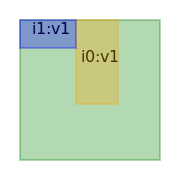

The objective_value_reached is -2.000000.
The mip_gap the solver returns for this solution is 0.0000. This means the solver has proven that
this solution, in terms of the objective, is *at most* 0.00% removed from the optimal solution.

-------------------- small_mip_qubo --------------------


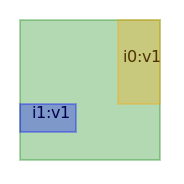

The objective_value_reached is -2.000000.

-------------------- small_ann_sw --------------------


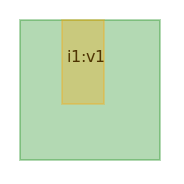


-------------------- small_ann_hw_cliq --------------------


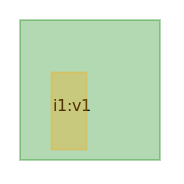


-------------------- small_ann_hw_dws --------------------


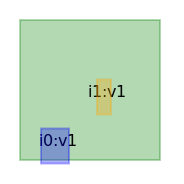


-------------------- small_ann_hw_hyb --------------------


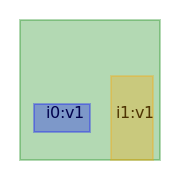

In [19]:
print('In each table rectangle, the number \'i\'-prefixed number refers to the table\'s index')
print('and the \'v\'-prefixed number to the value that table contributes to the objective value.')
for m in run_methods:
    print('\n-------------------- ' + problem_name + '_' + m + ' --------------------')
    
    display(SVG(svg_filename[m]))
    
    # in addition to showing the svg:
    if m in mip_methods:
        print('The objective_value_reached is {:f}.'.format(objective_value_reached[m]))
        if m == 'mip_plain':
            print('The mip_gap the solver returns for this solution is {:.4f}. This means the solver has proven that'.
                  format(mip_gap_reached[m]))
            print('this solution, in terms of the objective, is *at most* {:.2f}% removed from the optimal solution.'.
                  format(100 * mip_gap_reached[m]))    


-------------------- small_mip_plain --------------------


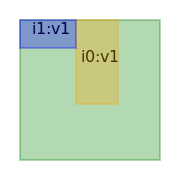


-------------------- small_mip_qubo --------------------


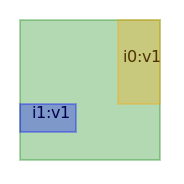


-------------------- small_ann_sw --------------------


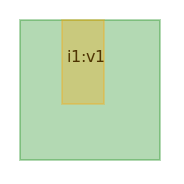


-------------------- small_ann_hw_cliq --------------------


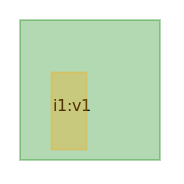


-------------------- small_ann_hw_dws --------------------


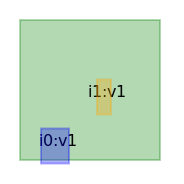


-------------------- small_ann_hw_hyb --------------------


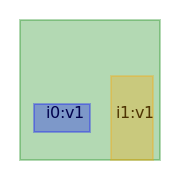


-------------------- medium_mip_plain --------------------


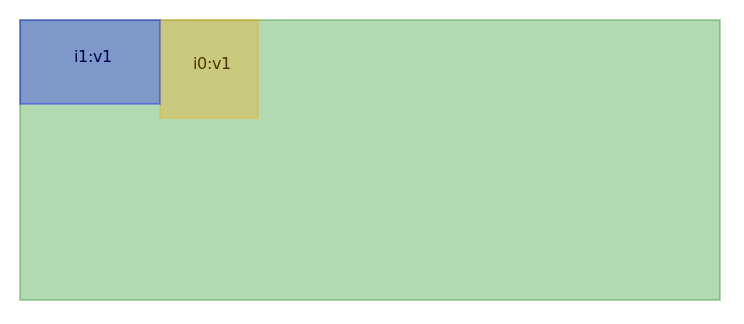


-------------------- medium_mip_qubo --------------------


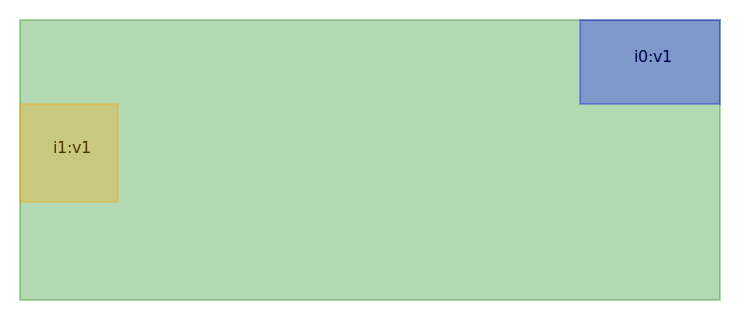


-------------------- medium_ann_sw --------------------


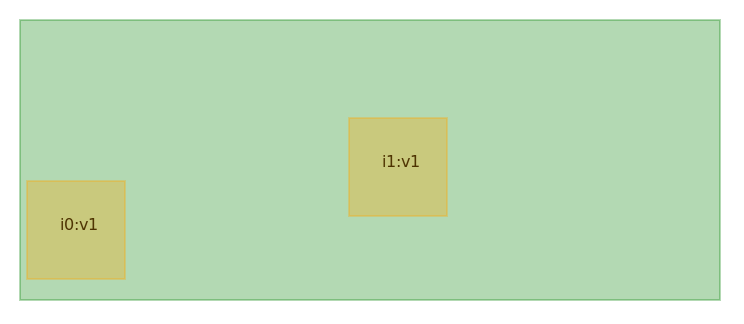


-------------------- medium_ann_hw_dws --------------------


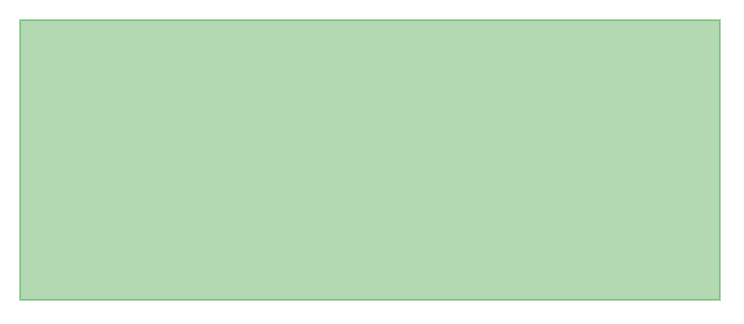


-------------------- medium_ann_hw_hyb --------------------


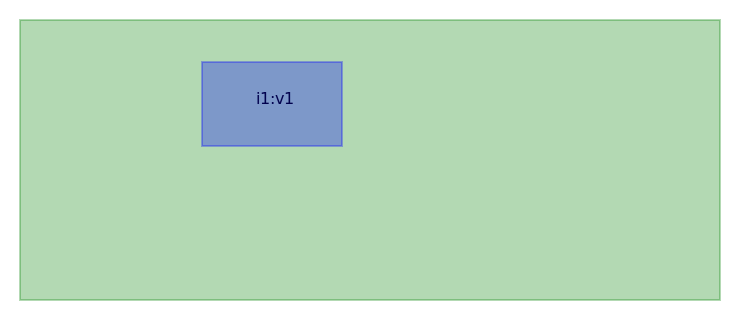


-------------------- large_mip_plain --------------------


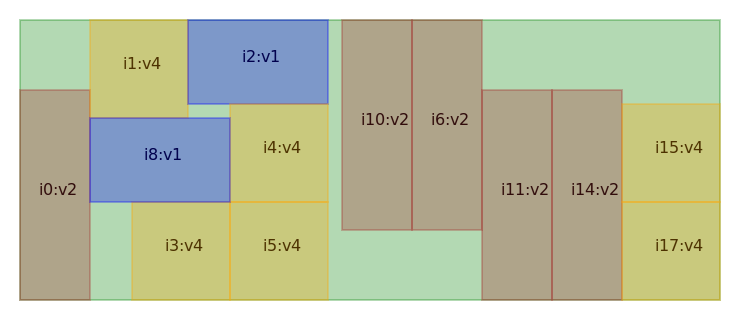


-------------------- large_mip_qubo --------------------


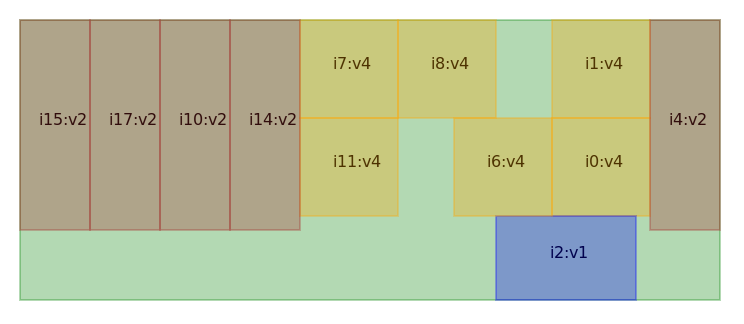


-------------------- large_ann_sw --------------------


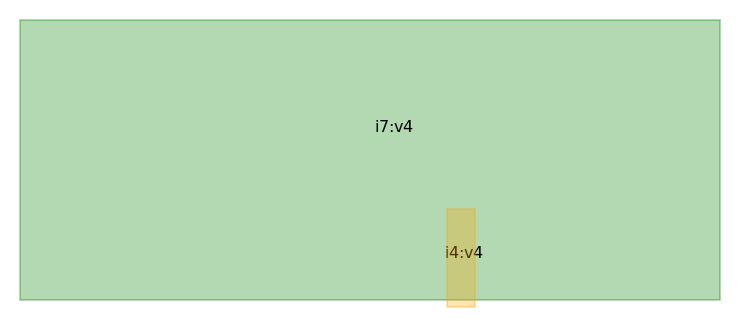


-------------------- large_ann_hw_hyb --------------------


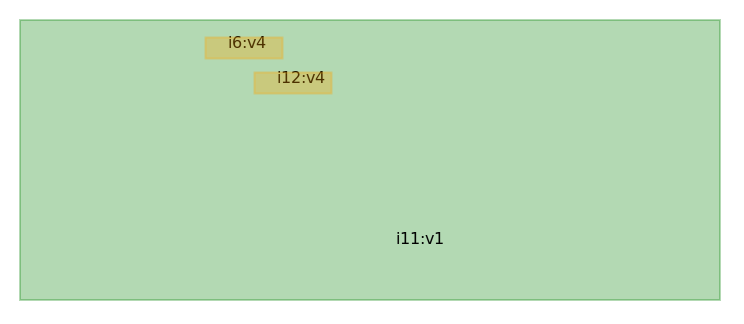

In [20]:
import os

for problem_name, problem_method_dict in all_cfg.items():
    problem = problem_method_dict['problem']
    methods = problem_method_dict['methods']
    for m in methods:
        print('\n-------------------- ' + problem_name + '_' + m + ' --------------------')
        svg_filename = '{:s}_{:s}_{:s}.svg'.format(filename_prefix, problem_name, m)
        # We assume the filename svg_filename has been written to disk before by running
        # the above at least once for each of the values ''small', 'medium' and 'large' for problem before.
        if os.path.exists(svg_filename):
            display(SVG(svg_filename))
        else:
            print("File '{:s}' does not exist (yet).".format(svg_filename))

# Results Summary

From the svg pictures in the previous cell we can summarize the results as follows.

For the small problem we get valid solutions for all methods except for small_ann_hw_dws
small_mip_plain: valid, optimal :)
small_mip_qubo: valid, optimal :)
small_ann_sw: valid, suboptimal :|
small_ann_hw_cliq: valid, suboptimal :|
small_ann_hw_dws: invalid :(
small_ann_hw_hyb: valid, optimal :)

For the medium problem we get valid solutions: 
medium_mip_plain: valid, optimal :)
medium_mip_qubo: valid, optimal :)
medium_ann_sw: valid, optimal :)
medium_ann_hw_cliq: not enough qubits, :(
medium_ann_hw_dws: valid, suboptimal (0 tables placed) :|
medium_ann_hw_hyb: valid, suboptimal :|

For the large problem we get valid solutions: 
large_mip_plain: valid, optimal(13 tables placed) :)
large_mip_qubo: valid, optimal(12 tables placed) :)
large_ann_sw: invalid :( 
large_ann_hw_cliq: not enough qubits, :(
large_ann_hw_dws: no embedding solution found :(
large_ann_hw_hyb: invalid :(



# Conclusions for now, for this problem type

## The MIP methods return solutions that were always valid. 

This is natural for the mip_plain methods since it encodes the hard constraints as ... well... hard oncstrainst, so no solution can come out that does not respect these hard constraints. 

This is less obvious for the mip_qubo method, since the hard mip_plain constraints are are here formulated as terms of type p * (f(x)-c)^2 terms in the objective function. Nevertheless, in this notebook, for all 3 problems (small, medium, large) we get valid solutions returned (in the sense that these p * (f(x)-c)^2 are all zero.

## Annealing methods can return valid solutions but more often returned invalid ones

For the annealing methods, I have set up the same objective function as for mip_qubo (for which all three problems give good solutions on a classical computer: my laptop, running the Gurobi solver). So one would expect that when one encodes this same expression on a quantum computer (or software(sw)-simulator, for method 'ana_sw'), one would get valid solutions as well. However, as seen above, there are constraints violated (reported by the same tool pyqubo that sets up these constraints for me) in the returned solutions.
This can have to do with 'only' sampling a 1000 samples from the quantum machine and so not obtaining the fully optimal sample with the very lowest energy (where (f(x)-c)^2 should all be zero).

For now, for this kind of problems, where one has hard constraints in the mip, it still seems
an easier path to guaranteed valid solutions.

I would of course be interested in knowing how to avoid invalid solutions if anyone has tips...

best,

Peter